# Отчет

### Основная идея

Мы решали задачу выделения аспектов в отзывах и оценки тональности по аспектам и категориям с помощью sequence-labeling. Для этого мы использовали предобученную языковую transformer модель. 

Содержание:
1. Данные и модель
3. Методы
    - модель для оценки тональности по категориям
    - модели для выделения аспектов и оценки их тональности
    - joint модель для выделения аспектов и оценки их тональности
4. Результаты

## Данные

В качестве данных мы использовали только те, которые были предложены для решения задачи. Папйплайн предобработки данных следующий:
1. Разделили индексы отзывов на train/valid/test в пропорциях 0.8/0.1/0.1
2. Для задачи оценки тональности по категориям был собран датафрейм со следующими колонками: индекс, текст отзыва, оценка сентимента по каждой категории
3. Для задачи выделения аспектов и оценки их тональности текст отзывов был токенизирован и каждому токену был присвоен лейбл в BIO нотации с соответствующей категорией, а также присвоен лейбл с сентиментом. Даасет был так же собран в датафрейм с колонками: индекс, токен, лейбл категории, лейбл сентимента.

Все данные находятся в папке [`data/`](https://github.com/yuliya1324/Aspect_Sent_project/tree/main/data) в формате `.csv` с названием `<task>_<split>.csv`

Датасет для задачи оценки тональности по категориям

In [3]:
import pandas as pd

df_cat = pd.read_csv('data/cats_train.csv', index_col=0)
df_cat.head()

,idx,text,Food,Interior,Price,Whole,Service
0,3976,"День 8-го марта прошёл, можно и итоги подвести...",positive,positive,absence,positive,positive
1,30808,Отмечали в этом ресторане день рождение на пер...,positive,positive,positive,positive,positive
2,14031,Хочу поделиться своим впечатлением от посещени...,absence,positive,absence,positive,positive
3,2495,Добрый день! Были вчера с друзьями в этом кафе...,positive,positive,absence,positive,positive
4,38835,Отметили с мужем годовщину свадьбы 6 ноября в ...,both,absence,negative,negative,positive


Датасет для задачи выделения аспектов и оценки их тональности

In [4]:
df_aspect = pd.read_csv('data/aspects_train.csv', index_col=0)
df_aspect.head()

,idx,tokens,class,sentiment
0,3976,День,O,no
1,3976,8-го,O,no
2,3976,марта,O,no
3,3976,прошёл,O,no
4,3976,",",O,no


В качестве языковой модели мы взяли предобученную модель [`sberbank-ai/ruRoberta-large`](https://huggingface.co/sberbank-ai/ruRoberta-large). Эта модель очень большая, в ней 355 M параметров, поэтому она аккумулирует в себе достаточно много знаний о русском языке. Для данной задачи мы файнтюнили только последние слои (20-23) и соответствующие классификационные головы. 

## Методы

[Отчет с графиками экспериментов и описанием параметров](https://github.com/yuliya1324/Aspect_Sent_project/blob/main/report.pdf)

### Модель для оценки тональности по категориям

Для данной задачи мы сделали модель, которая классифицирует сентименты сразу по всем категориям. Она состоит из общего тела энкодера и пяти классификационных голов на каждую категорию, при этом каждая голова предсказывает один из 5 классов `["absence", "positive", "negative", "both", "neutral"]`. 

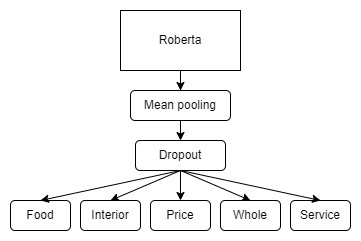

Эмбеддинги из энекодера суммируются, проходят через дропаут с вероятностю 0.5, и классификация происходит по одному эмбеддингу всего отзыва. Лосс суммировался по всем категориям. [Тетрадка с экспериментом](https://github.com/yuliya1324/Aspect_Sent_project/blob/main/experiments/cats.ipynb)

### Модели для выделения аспектов и оценки их тональности

Задачу с аспектами мы разделили на две: тегирование токенов по категориям и классификация по сентиментам. Для обеих задач мы делали token classification двумя разными моделями. Для первой задачи классификация происходила по 11 классам: `{
            "O": 0, 
            "B-Food": 1, 
            "I-Food": 2, 
            "B-Interior": 3,
            "I-Interior": 4, 
            "B-Price": 5,
            "I-Price": 6, 
            "B-Whole": 7, 
            "I-Whole": 8, 
            "B-Service": 9, 
            "I-Service": 10,
            }`. 
Для второй по 3: `{"positive": 0, "negative": 1, "neutral": 2, "both": 3}`. Для второй задачи токены, у которых нет лейбла сентимента тегировались падингом, чтобы через них не проходил градиент. На инференсе мы сначала предсказываем категорию, и потом для тех токенов, которым была присвоена категория, предсказываем тональность. Тональность спану присваивается по тональности первого токена спана.

- [Тетрадка с экспериментами предсказания категорий аспектов](https://github.com/yuliya1324/Aspect_Sent_project/blob/main/experiments/aspects_cat.ipynb)

- [Тетрадка с экспериментами оценки тональности аспектов](https://github.com/yuliya1324/Aspect_Sent_project/blob/main/experiments/aspects_sent.ipynb)

### Joint модель для выделения аспектов и оценки их тональности

Мы решили попробовать использовать одну модель для решения сразу двух задач: выделения аспектов и предсказания тональности. По эмбеддингам из Роберты сначала предсказывается тег категории, потом он конкатенируется с эмбеддингом из Роберты и предсказывается тональность уже по 4 классам (добавляется класс отсутствия тональности).

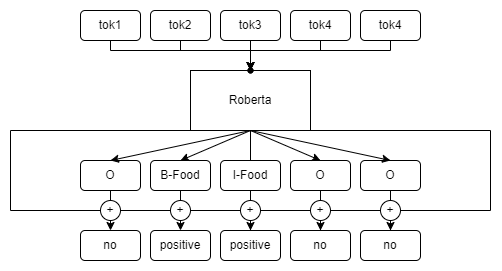

Этот метод дал результаты немного похуже раздельных моделей, поэтому в качестве  финальной версии мы выбрали предыдущий вариант. [Тетрадка с экспериментами](https://github.com/yuliya1324/Aspect_Sent_project/blob/main/experiments/Sent_joint.ipynb)